In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = todos los mensajes, 1 = INFO, 2 = WARNING, 3 = ERROR
import numpy as np
import keras
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
from matplotlib import cm
from scipy.ndimage import label

In [2]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.scorecam import Scorecam

In [3]:
from data import part_classes, animals

In [4]:
IMG_SIZE = (360,360)#468)
total_pixels = IMG_SIZE[0]*IMG_SIZE[1]
pixel_region = round(total_pixels*0.02)

In [5]:
OPTION = 1
if OPTION == 1:
    model_name = 'xception_without_model'
    data_metrics_file = 'dataset_info_parts_metrics_methods_without'
else:
    model_name = 'xception_model'
    data_metrics_file = 'dataset_info_parts_metrics_methods'

In [6]:
model = tf.keras.models.load_model(model_name+'.h5')
conv_layers= [l.name for l in model.layers if 'conv' in l.name and not l.name.endswith('act') and not l.name.endswith('bn')]#l.__class__.__name__.endswith('Conv2D')]# and 'sepconv' not in l.name]
last_conv_layer_name = conv_layers[-1]
last_conv_layer_name = 'add_10'

In [7]:
for l in model.layers:
    print(l.name)

input_1
tf.math.truediv
tf.math.subtract
block1_conv1
block1_conv1_bn
block1_conv1_act
block1_conv2
block1_conv2_bn
block1_conv2_act
block2_sepconv1
block2_sepconv1_bn
block2_sepconv2_act
block2_sepconv2
block2_sepconv2_bn
conv2d
block2_pool
batch_normalization
add
block3_sepconv1_act
block3_sepconv1
block3_sepconv1_bn
block3_sepconv2_act
block3_sepconv2
block3_sepconv2_bn
conv2d_1
block3_pool
batch_normalization_1
add_1
block4_sepconv1_act
block4_sepconv1
block4_sepconv1_bn
block4_sepconv2_act
block4_sepconv2
block4_sepconv2_bn
conv2d_2
block4_pool
batch_normalization_2
add_2
block5_sepconv1_act
block5_sepconv1
block5_sepconv1_bn
block5_sepconv2_act
block5_sepconv2
block5_sepconv2_bn
block5_sepconv3_act
block5_sepconv3
block5_sepconv3_bn
add_3
block6_sepconv1_act
block6_sepconv1
block6_sepconv1_bn
block6_sepconv2_act
block6_sepconv2
block6_sepconv2_bn
block6_sepconv3_act
block6_sepconv3
block6_sepconv3_bn
add_4
block7_sepconv1_act
block7_sepconv1
block7_sepconv1_bn
block7_sepconv2_act

In [8]:
conv_layers, last_conv_layer_name #block14_sepconv2_act

(['block1_conv1',
  'block1_conv2',
  'block2_sepconv1',
  'block2_sepconv2',
  'conv2d',
  'block3_sepconv1',
  'block3_sepconv2',
  'conv2d_1',
  'block4_sepconv1',
  'block4_sepconv2',
  'conv2d_2',
  'block5_sepconv1',
  'block5_sepconv2',
  'block5_sepconv3',
  'block6_sepconv1',
  'block6_sepconv2',
  'block6_sepconv3',
  'block7_sepconv1',
  'block7_sepconv2',
  'block7_sepconv3',
  'block8_sepconv1',
  'block8_sepconv2',
  'block8_sepconv3',
  'block9_sepconv1',
  'block9_sepconv2',
  'block9_sepconv3',
  'block10_sepconv1',
  'block10_sepconv2',
  'block10_sepconv3',
  'block11_sepconv1',
  'block11_sepconv2',
  'block11_sepconv3',
  'block12_sepconv1',
  'block12_sepconv2',
  'block12_sepconv3',
  'block13_sepconv1',
  'block13_sepconv2',
  'conv2d_3',
  'block14_sepconv1',
  'block14_sepconv2'],
 'add_10')

In [9]:
df = pd.read_csv('dataset_info_parts.csv')
PATH_data = 'dataset/'
IMG_RESIZE_PATH_data = PATH_data+'images_resize/'
ANN_RESIZE_PATH_data = PATH_data+'annotations_resize/'
IMG_SIZE = (360,360)#468)
BATCH_SIZE = 32
df['file_path'] = IMG_RESIZE_PATH_data + df['file']+'.jpg'
animals = ['sheep', 'dog', 'cow', 'cat', 'horse']

df[['pred_id', 'pred_ok', 'cat_id']] = np.nan
df[['mean_act_obj', 'mean_act_back', 'perc_act_obj', 'perc_act_back']] = np.nan
#df[['mean_act_head', 'mean_act_torso', 'mean_act_leg', 'perc_act_head', 'perc_act_torso', 'perc_act_leg']] = np.nan

In [10]:
replace2linear = ReplaceToLinear()
gradcam = Gradcam(model, model_modifier=replace2linear, clone=True)
gradcamplus = GradcamPlusPlus(model, model_modifier=replace2linear, clone=True)
scorecam = Scorecam(model, model_modifier=replace2linear)
methods = {'gradcam':[gradcam,df.copy(), 'GradCAM','block14_sepconv2_act'], 'gradcamplus': [gradcamplus,df.copy(), 'GradCAM++', 'add_11'], 'scorecam':[scorecam,df.copy(),'ScoreCAM', 'add_10']}

In [11]:
def get_metrics(mask, heatmap_resize, threshold=0.5, masks=False):
    object_mask = (mask != 0)*1
    background_mask = (mask == 0)*1
    
    heatmap_object_values = heatmap_resize[object_mask == 1]
    mean_activation_object = np.mean(heatmap_object_values)
    if np.count_nonzero(heatmap_object_values) == 0:
        percent_object_activated = 0
    else:
        percent_object_activated = np.count_nonzero(heatmap_object_values >= threshold) / np.count_nonzero(heatmap_object_values) 
    
    heatmap_background_values = heatmap_resize[background_mask == 1]
    mean_activation_background = np.mean(heatmap_background_values)
    if np.count_nonzero(heatmap_background_values) == 0:
        percent_background_activated = 0
    else:
        percent_background_activated = np.count_nonzero(heatmap_background_values >= threshold) / np.count_nonzero(heatmap_background_values)

    metrics = {
        'mean_act_obj': mean_activation_object,
        'mean_act_back': mean_activation_background,
        'perc_act_obj': percent_object_activated,
        'perc_act_back': percent_background_activated,
    }

    if not masks:
        return metrics
    else:
        heatmap_object = heatmap_resize * object_mask
        heatmap_background = heatmap_resize * background_mask
        heatmap_object_th = (heatmap_object >= threshold)*1
        heatmap_object[background_mask == 1] = -1
        heatmap_object_th[background_mask == 1] = -1
        heatmap_background_th = (heatmap_background >= threshold)*1
        heatmap_background[object_mask == 1] = -1
        heatmap_background_th[object_mask == 1] = -1
        return metrics, [object_mask, background_mask], [heatmap_object, heatmap_background], [heatmap_object_th, heatmap_background_th]

In [12]:
def get_hact_parts(f_mask, mask_part):
    dict_mask = {}
    for part in ['background','object', 'head', 'torso', 'leg']:
        if part=='object':
            mask_part = mask
        elif part=='background':
            mask_part = np.invert(mask)
        else:
            part_id = part_classes[part][0]
            mask_part = mask_parts[:,:,part_id-1]
        union_mask = np.logical_and(f_mask, mask_part)
        pixels_part = np.count_nonzero(mask_part)
        if pixels_part == 0:
            dict_mask[part]= 0
        else:
            dict_mask[part]= np.count_nonzero(union_mask)/pixels_part
    act_mask_sorted = dict(sorted(dict_mask.items(), key=lambda item: item[1], reverse=True))
    hact_parts = {}
    for key,value,i in zip(list(act_mask_sorted.keys())[:3], list(act_mask_sorted.values())[:3], range(1,4)):
        hact_parts['hact_'+str(i)+'_part'] = key
        hact_parts['hact_'+str(i)+'_perc'] = value
    return hact_parts

In [13]:
def find_largest_active_region_iterative(gradcam_mask, min_region_size=pixel_region, step=0.05):
    threshold = 1.0
    best_region = None

    while threshold > 0:
        binary_mask = (gradcam_mask >= threshold).astype(np.uint8)
        labeled_mask, num_features = label(binary_mask)

        if num_features == 0:
            threshold -= step
            continue

        counts = np.bincount(labeled_mask.flatten())
        # Excluimos fondo (etiqueta 0)
        counts[0] = 0

        largest_label = counts.argmax()
        largest_size = counts[largest_label]

        if largest_size >= min_region_size:
            # Región válida encontrada, devolverla
            best_region = (labeled_mask == largest_label).astype(np.uint8)
            break

        threshold -= step

    if best_region is None:
        # No se encontró región con tamaño mínimo, devolver máscara vacía
        best_region = np.zeros_like(gradcam_mask, dtype=np.uint8)

    return best_region

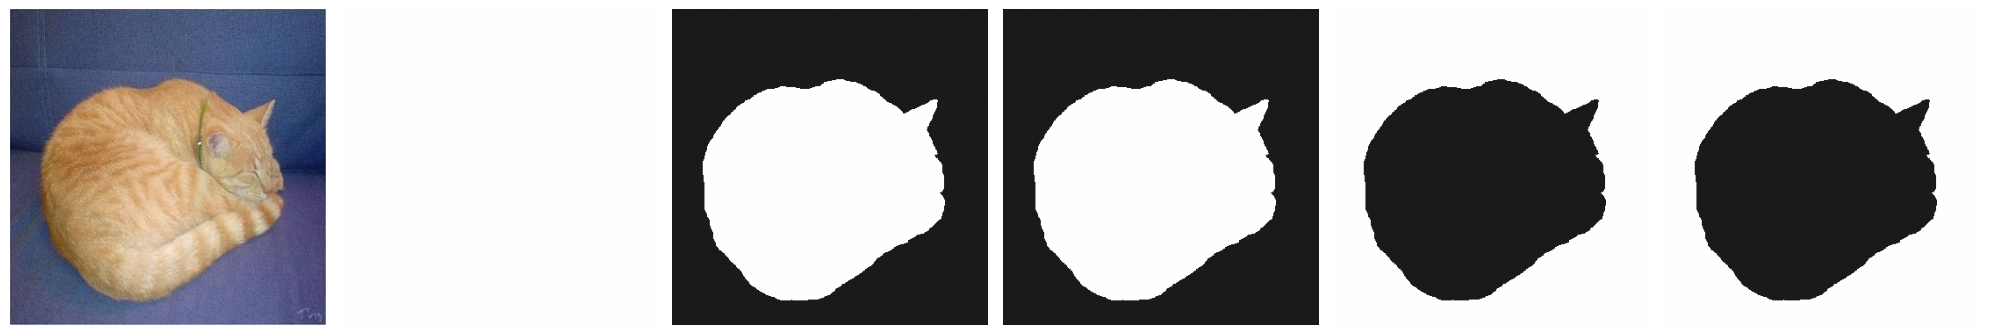

1/1 [==============================] - 3s 3s/step


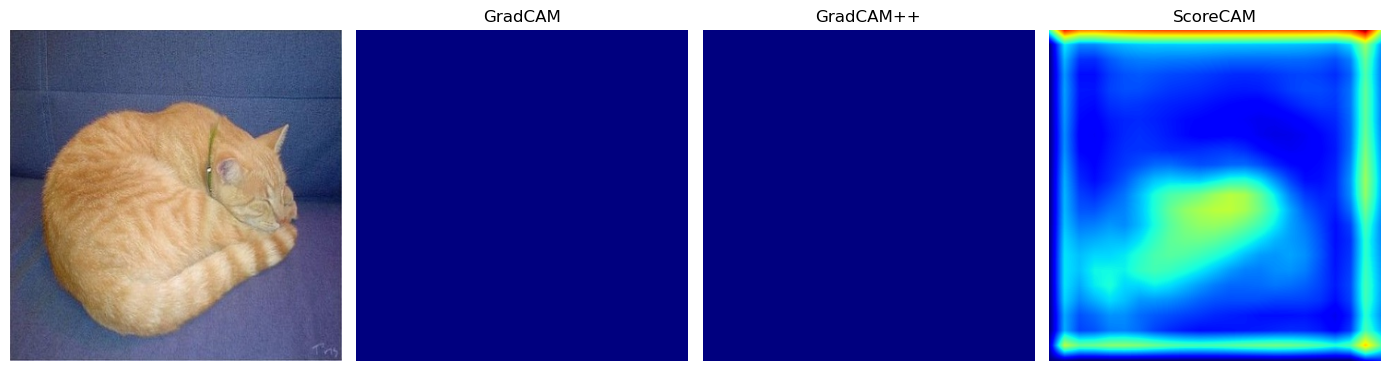

In [14]:
activations = []

for index, row in df.iterrows():
    cat_id = animals.index(row['cat'])
    img = cv2.cvtColor(cv2.imread(row.file_path),cv2.COLOR_BGR2RGB)
    mask = cv2.imread(os.path.join(ANN_RESIZE_PATH_data,row.file+'_mask.png'),cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, IMG_SIZE)
    mask = cv2.resize(mask, IMG_SIZE)
    array = np.expand_dims(img.astype(np.float32), axis=0)
    predictions = model.predict(array, verbose=False)
    predicted_index = np.argmax(predictions[0])  
    score = CategoricalScore([predicted_index]) 

    for method_name, (method, data, m_show, last_conv_layer_name) in methods.items():
        data.loc[index, 'method'] = method_name
        data.loc[index, 'cat_id'] = cat_id
        data.loc[index, 'pred_id'] = predicted_index
        data.loc[index, 'pred_ok'] = int(predicted_index == cat_id)

        if method_name!='scorecam':
            cam = method(score, array, penultimate_layer=last_conv_layer_name)
        else:
            cam = method(score, array, penultimate_layer=last_conv_layer_name, max_N=10)
        #heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
        activations.append(cam[0])

        metrics, masks, heatmaps, heatmaps_th = get_metrics(mask, cam[0], masks=True)
        for key, value in metrics.items():
            data.loc[index, key] = value

        if method_name=='gradcam':
            fig, axs = plt.subplots(1,6, figsize=(20,4))
            axs[0].imshow(img)
            axs[1].imshow(-cam[0],cmap='RdGy', vmin=-1, vmax=1)
            axs[2].imshow(-heatmaps[0],cmap='RdGy', vmin=-1, vmax=1)
            axs[3].imshow(-heatmaps_th[0],cmap='RdGy', vmin=-1, vmax=1)
            axs[4].imshow(-heatmaps[1],cmap='RdGy', vmin=-1, vmax=1)
            axs[5].imshow(-heatmaps_th[1],cmap='RdGy', vmin=-1, vmax=1)
            for i in range(6):
                axs[i].axis('off')   
            plt.tight_layout()
            plt.savefig('images/activation_'+str(OPTION)+'_masks.png')
            plt.show()
    fig, axs = plt.subplots(1,4, figsize=(14,4))
    axs[0].imshow(img)
    i = 0
    for method_name, (method, data, m_show, _) in methods.items():
        heatmap = np.uint8(cm.jet(activations[i])[..., :3] * 255)
        axs[1+i].imshow(heatmap)
        axs[1+i].set_title(m_show)
        i+=1
    for i in range(4):
        axs[i].axis('off')   
    plt.tight_layout()
    plt.savefig('images/activation_'+str(OPTION)+'_methods.png')
    plt.show()
    break
    

In [15]:
def occlusion_region(img, mask, porcentaje=0.3, color=(0, 0, 0), max_intentos=20):
    img_ocluida = img.copy()
    mask_bin = (mask > 0).astype(np.uint8)

    coords = np.column_stack(np.where(mask_bin == 1))
    if coords.shape[0] == 0:
        return img_ocluida  # Nada que ocluir

    # Bounding box
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)

    altura_box = y_max - y_min + 1
    anchura_box = x_max - x_min + 1
    area_total = mask_bin.sum()
    area_objetivo = int(area_total * porcentaje)

    for _ in range(max_intentos):
        # Probar tamaños más pequeños pero razonables
        h = np.random.randint(5, altura_box + 1)
        w = int(area_objetivo / h)
        if w < 5 or w > anchura_box:
            continue  # Ancho inválido

        # Posición aleatoria dentro del bounding box
        max_top = y_max - h + 1
        max_left = x_max - w + 1
        if max_top < y_min or max_left < x_min:
            continue

        top = np.random.randint(y_min, max_top + 1)
        left = np.random.randint(x_min, max_left + 1)

        submask = mask_bin[top:top + h, left:left + w]
        if submask.sum() / area_objetivo >= 0.6:
            for c in range(3):
                img_ocluida[top:top + h, left:left + w, c][submask == 1] = color[c]
            return img_ocluida

    return img_ocluida


In [16]:
data_metrics = pd.DataFrame([],columns=data.columns)

for index, row in df.iterrows():
    print('\n======================================================================')
    print('\tImage '+str(index)+' of '+str(df.shape[0]))
    print(row.file_path)
    cat_id = animals.index(row['cat'])
    img = cv2.cvtColor(cv2.imread(row.file_path),cv2.COLOR_BGR2RGB)
    mask = cv2.imread(os.path.join(ANN_RESIZE_PATH_data,row.file+'_mask.png'),cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, IMG_SIZE)
    mask = cv2.resize(mask, IMG_SIZE)

    images = np.array([img])
    images_info = [{'oc_part':None, 'oc_part_perc':0}]
    #images.append([img, None, 0])
    if os.path.isfile(os.path.join(ANN_RESIZE_PATH_data,row.file+'_parts.npy')):
        mask_parts = np.load(os.path.join(ANN_RESIZE_PATH_data,row.file+'_parts.npy'))
        mask_parts = cv2.resize(mask_parts, IMG_SIZE)
        for part in ['object', 'head', 'torso', 'leg']:
            if part=='object':
                mask_part = mask
            else:
                part_id = part_classes[part][0]
                mask_part = mask_parts[:,:,part_id-1]
            for p in [0.25,0.5,0.75,1]:                
                img_oclusion = occlusion_region(img, mask_part, porcentaje=p)
                #images.append([img_oclusion, part, p])
                images_info.append({'oc_part':part, 'oc_part_perc':p})
                images = np.concatenate([images,np.array([img_oclusion])], axis=0)
    """
    fig, axs = plt.subplots(1, len(images), figsize=(25,4))
    for i,im in enumerate(images):
        axs[i].imshow(im[0])
        axs[i].set_title(str(im[1])+' '+str(im[2]))
    plt.show()
    """

    array = images.astype(np.float32)
    predictions = model.predict(array, verbose=False)
    predicted_index = np.argmax(predictions,axis=1)  
    predicted_prob = np.max(predictions, axis=1) 
    

    for i, info in enumerate(images_info):
        score = CategoricalScore([predicted_index[i]])
        for method_name, (method, data, m_show, last_conv_layer_name) in methods.items():
                
            if method_name!='scorecam':
                cam = method(score, array[i,:,:], penultimate_layer=last_conv_layer_name)
            else:
                cam = method(score, array[i,:,:], penultimate_layer=last_conv_layer_name, max_N=10) 
            metrics, masks, heatmaps, heatmaps_th = get_metrics(mask, cam[0], masks=True)
            f_mask = find_largest_active_region_iterative(cam[0])
            hact_values = get_hact_parts(f_mask, mask_part)
            row_dict = dict(row)
            row_dict['oc_part']=info['oc_part']
            row_dict['oc_part_perc']=info['oc_part_perc']
            row_dict['pred_id'] = predicted_index[i]
            row_dict['pred_prob'] = predicted_prob[i]
            row_dict['cat_id'] = cat_id
            row_dict['pred_ok'] = int(predicted_index[i] == cat_id)            
            row_dict['method'] = method_name
            for key, value in metrics.items():
                row_dict[key] = value       
            for key, value in hact_values.items():
                row_dict[key] = value 
            df_row = pd.DataFrame([row_dict])    
            data_metrics = pd.concat([data_metrics, df_row], ignore_index=True)
    data_metrics.to_csv(data_metrics_file+'.csv', index=False)


	Image 0 of 417
dataset/images_resize/2008_000181.jpg


C:\Users\virgi\AppData\Local\Temp\ipykernel_4456\3182032997.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_metrics = pd.concat([data_metrics, df_row], ignore_index=True)


1/1 [==============================] - 0s 101ms/step

	Image 1 of 417
dataset/images_resize/2008_000696.jpg
1/1 [==============================] - 0s 106ms/step

	Image 2 of 417
dataset/images_resize/2008_000905.jpg
1/1 [==============================] - 0s 99ms/step

	Image 3 of 417
dataset/images_resize/2008_000915.jpg
1/1 [==============================] - 0s 103ms/step

	Image 4 of 417
dataset/images_resize/2008_001137.jpg
1/1 [==============================] - 0s 105ms/step

	Image 5 of 417
dataset/images_resize/2008_001278.jpg
1/1 [==============================] - 0s 96ms/step

	Image 6 of 417
dataset/images_resize/2008_001285.jpg
1/1 [==============================] - 0s 101ms/step

	Image 7 of 417
dataset/images_resize/2008_001872.jpg
1/1 [==============================] - 0s 93ms/step

	Image 8 of 417
dataset/images_resize/2008_002177.jpg
1/1 [==============================] - 0s 90ms/step

	Image 9 of 417
dataset/images_resize/2008_002294.jpg
1/1 [===========================